# Alzheimer prediction using gray matter density from T1w MRI 

**NB: It is important to mention that running the code will make the obtained values different from the ones in the responses.thank you for your understanding**<br>
**NB: since we are comparing different classifiers, i kept till the end the accuracy scoring function.**

**Deadline**: Upload this notebook (rename it as 'TP4-Trees-YOUR-SURNAME.ipynb') with your answers and code to the Moodle/Ecampus before the deadline.


We will use a dataset composed of neuroimaging features from brain T1w MR images of 752 subjects, 416 controls and 336 with Alzheimer’s disease. Following the pipeline described in [1], all images are first normalized to a
common space, providing a voxel-wise correspondence across subjects. Then, gray matter density is computed at each voxel and averaged over a set of ROIs (Region of Interest) of an atlas, at the beginning you will use the [AAL2 atlas](http://www.gin.cnrs.fr/en/tools/aal/). Data comes from several freely available datasets, like [ADNI](http://adni.loni.usc.edu/) and [OASIS](https://www.oasis-brains.org/), and has been pre-processed by the [Clinica](http://www.clinica.run/) team using the procedure explained in [1].

Please load the data from the file: *dataTP.npz* where *T1xxxx* is a matrix containing the averaged density (each row is a subject and each column a feature), *y* is a vector containing the diagnosis (0 for controls and 1 for Alzheimer’s patients) and *ROIlabelsx* contains the name of the ROI of each feature. Here, *x* can take the name of the three atlases you have at your disposal: AAL2, [AICHA](http://www.gin.cnrs.fr/fr/outils/aicha/), [HAMMERS](https://brain-development.org/brain-atlases/adult-brain-atlases/).

**Reference**:
[1] J. Samper-González, N. Burgos, S. Bottani, S. Fontanella, P. Lu, A. Marcoux, A. Routier, J. Guillon, M. Bacci, J. Wen, A. Bertrand, H. Bertin, M.-O. Habert, S. Durrleman, T. Evgeniou, O. Colliot. *Reproducible evaluation of classification methods in Alzheimer's disease: framework and application to MRI and PET data*. NeuroImage, 2018 

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import warnings
warnings.filterwarnings('ignore', category=ImportWarning)

# Libraries
import numpy as np
import matplotlib.pyplot as plt
!pip install -q nilearn
from nilearn import plotting
%matplotlib inline
np.random.seed(seed=666)

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler



In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='11cQmPm64k3T7ml5fPLetZgb1j1AjHBH8',
dest_path='./dataTP.npz')
gdd.download_file_from_google_drive(file_id='1S7e5IrPygE4VV0JTwqJIlyO2S_NhsiI4',
dest_path='./AtlasAAL2.nii')
gdd.download_file_from_google_drive(file_id='1E0pu5jIMpgcs2DQ8lBGWliwEBZvKrnV9',
dest_path='./AtlasAICHA.nii')
gdd.download_file_from_google_drive(file_id='1yltKwULrkHYh79RAh_zAg08r8pQMjRlQ',
dest_path='./AtlasHAMMERS.nii')

with np.load('/content/dataTP.npz',allow_pickle=True) as data:
    T1AAL2 = data['T1AAL2'] # data from AAL2 Atlas
    T1AICHA = data['T1AICHA'] # data from AICHA Atlas
    T1HAMMERS = data['T1HAMMERS'] # data from HAMMERS Atlas  
    y = data['y'] # classes, 0 for controls and 1 for patients    
    ROIlabelsAAL2 = data['ROIlabelsAAL2'] # labels for ROIs of atlas AAL2 
    ROIlabelsAICHA = data['ROIlabelsAICHA']    # labels for ROIs of atlas AICHA 
    ROIlabelsHAMMERS = data['ROIlabelsHAMMERS']    # labels for ROIs of atlas HAMMERS 

In [ ]:
# Choose Atlas (here AAL2)
X=T1AAL2 # T1AAL2, T1AICHA, T1HAMMERS
labels=ROIlabelsAAL2 # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas='./AtlasAAL2.nii' #AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 120


Using the library nilearn we can also plot the atlas used to define the ROIs:

/usr/local/lib/python3.7/dist-packages/nilearn/plotting/img_plotting.py:348: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


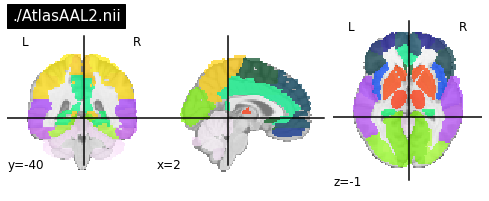

In [ ]:
plotting.plot_roi(atlas, title=atlas)
plotting.show()

In this TP we will use Decision Trees, Bagging and Random Forests. Let's start with Decision Trees. First of all, we need to create a training and test set.

**Answer:**
* I used stratify to preserve the same proportions of examples in each class as observed in the original dataset.

In [ ]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify=y)

And then we need to check whether out features need to be standardized or normalized. Let's have a look at them. Remember that if features can have both negative and positive values, as a rule of thumb, they should be standardized. If they only have positive values, a normalization is usually used. 

As already said, please remember that you should learn the standardization/normalization (namely learn the average/std or the max/min values) ONLY in the training set and then use the same values also in the test set. You should NOT use the entire dataset (both training and test) for standardization/normalization. Otherwise, you would have a *data leakage*, namely you would use data (the test set) that you should not use during training. 

**Answer:**
* I will start with checking whether we have positive and negative values or only positive values:

In [ ]:
print('the minimal value of a feature', X.min())
print('the maximal value of a feature', X.max())

the minimal value of a feature 0.0
the maximal value of a feature 0.885043542362


* Since we have only positive values, we will consider the normalization process :

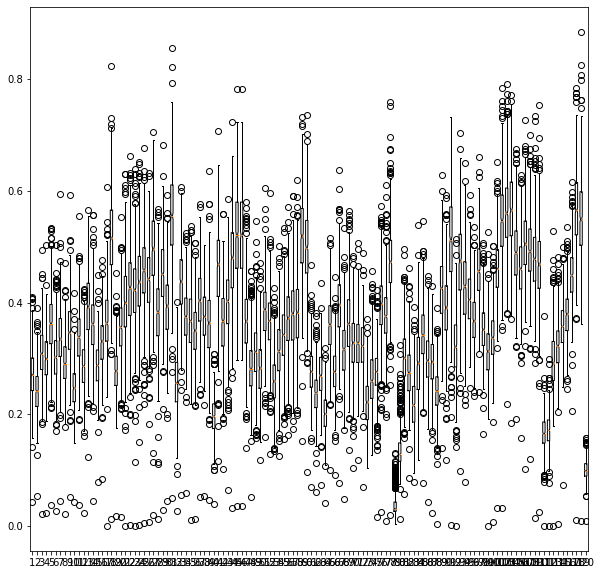

In [ ]:

plt.figure(figsize=(10,10))
plt.boxplot(X,notch=True);

# Standardization/Normalization
scaler = MinMaxScaler()
#fitting only the training set
scaler.fit(X_train)
# applying the learned params on the training and test sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Then, we can fit a Decision tree, with the default setting, using the following code:

In [ ]:
# Fitting Decision Trees 
Tree = DecisionTreeClassifier(random_state=0)
Tree.fit(X_train,y_train)
# Score in the training set
print('Score in the training set is {0}'.format(Tree.score(X_train,y_train)) )
# Score in the test set
print('Score in the test set is {0}'.format(Tree.score(X_test,y_test)) )

Score in the training set is 1.0
Score in the test set is 0.7553191489361702


Instead than using the default hyperparameters, we could also look for the best ones. Among the hyperparameters implemented in *scikit-learn* we could use *'min_samples_split'*, the minimum number of samples required to split an internal node, and/or *'min_samples_leaf'*, the minimum number of samples required to be present at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. 

Plot the training and test score for different values of 'min_samples_split' (for instance between 2 and 15) WITHOUT using Cross Validation. Do the same for 'min_samples_leaf'.

**Question:** What is the best value ? What happens if you split differently your data (change `random_state`in the function `train_test_split`) ? 


The value of min_samples_split that maximizes the training score is :  2
The value of min_samples_split that maximizes the test score is :  2


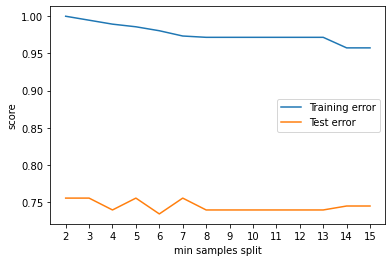

In [ ]:
# min_samples_split

TTest=[]
TTrain=[]
for i in range(2,16):
    Tree = DecisionTreeClassifier(min_samples_split=i, random_state=0)
    Tree.fit(X_train,y_train)
    scoreTrain=Tree.score(X_train,y_train)
    scoreTest=Tree.score(X_test,y_test)
    TTrain.append(scoreTrain)
    TTest.append(scoreTest)
plt.plot(TTrain,label='Training error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_split that maximizes the training score is : ",TTrain.index(max(TTrain))+2)
plt.plot(TTest,label='Test error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
plt.xlabel('min samples split')
plt.ylabel('score')
print("The value of min_samples_split that maximizes the test score is : ",TTest.index(max(TTest))+2)
plt.legend();

The value of min_samples_split that maximizes the training score is :  2
The value of min_samples_split that maximizes the test score is :  9


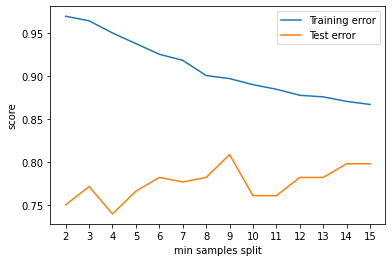

In [ ]:
# min_samples_leaf
TTest=[]
TTrain=[]
for i in range(2,16):
    Tree = DecisionTreeClassifier(min_samples_leaf=i, random_state=0)
    Tree.fit(X_train,y_train)
    scoreTrain=Tree.score(X_train,y_train)
    scoreTest=Tree.score(X_test,y_test)
    TTrain.append(scoreTrain)
    TTest.append(scoreTest)
plt.plot(TTrain,label='Training error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_split that maximizes the training score is : ",TTrain.index(max(TTrain))+2)
plt.plot(TTest,label='Test error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
plt.xlabel('min samples split')
plt.ylabel('score')
print("The value of min_samples_split that maximizes the test score is : ",TTest.index(max(TTest))+2)
plt.legend();

**Answer:**
* If we will make our choice according to the training score : 
    * min_sample_split = 2
    * min_sample_leaf = 2
* If we will make our choice according to the testing score :
    * min_sample_split = 2
    * min_sample_leaf = 9

#Changing the random_state

* Random_state=15

The value of min_samples_leaf that maximizes the training score is :  2
The value of min_samples_leaf that maximizes the test score is :  4


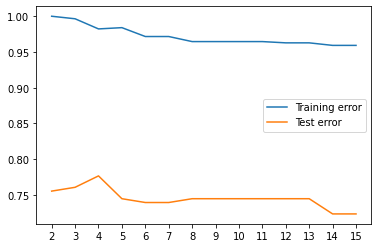

In [ ]:
X_train_15, X_test_15, y_train_15, y_test_15 = train_test_split(X, y, test_size=0.25, random_state=15,stratify=y)
scaler = MinMaxScaler()
scaler.fit(X_train_15)
X_train_15 = scaler.transform(X_train_15)
X_test_15 = scaler.transform(X_test_15)
TTest=[]
TTrain=[]
for i in range(2,16):
    Tree = DecisionTreeClassifier(min_samples_split=i, random_state=0)
    Tree.fit(X_train_15,y_train_15)
    scoreTrain=Tree.score(X_train_15,y_train_15)
    scoreTest=Tree.score(X_test_15,y_test_15)
    TTrain.append(scoreTrain)
    TTest.append(scoreTest)
plt.plot(TTrain,label='Training error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_leaf that maximizes the training score is : ",TTrain.index(max(TTrain))+2)
plt.plot(TTest,label='Test error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_leaf that maximizes the test score is : ",TTest.index(max(TTest))+2)
plt.legend();

The value of min_samples_leaf that maximizes the training score is :  2
The value of min_samples_leaf that maximizes the test score is :  5


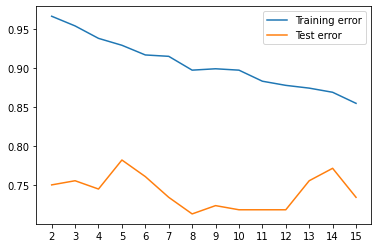

In [ ]:
X_train_15, X_test_15, y_train_15, y_test_15 = train_test_split(X, y, test_size=0.25, random_state=15,stratify=y)
scaler = MinMaxScaler()
scaler.fit(X_train_15)
X_train_15 = scaler.transform(X_train_15)
X_test_15 = scaler.transform(X_test_15)
TTest=[]
TTrain=[]
for i in range(2,16):
    Tree = DecisionTreeClassifier(min_samples_leaf=i, random_state=0)
    Tree.fit(X_train_15,y_train_15)
    scoreTrain=Tree.score(X_train_15,y_train_15)
    scoreTest=Tree.score(X_test_15,y_test_15)
    TTrain.append(scoreTrain)
    TTest.append(scoreTest)
plt.plot(TTrain,label='Training error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_leaf that maximizes the training score is : ",TTrain.index(max(TTrain))+2)
plt.plot(TTest,label='Test error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_leaf that maximizes the test score is : ",TTest.index(max(TTest))+2)
plt.legend();

**Answer:**
* It is clear that when we changed the value of random_state ( split the data differently), the best hyperparameters changed with the testing score.
* This is logical since we are dealing with decision trees and we know that decision trees has a big variance. This means that a little change in data could lead to another tree.

Try to add Gaussian noise to the data (using for instance zero mean and 0.05 for $\sigma$) and, using the best hyperparameters found before in the test set (you can use both `min_samples_leaf` and `min_samples_split`), look at the test score. Repeat this process several times and compare the results with the score obtained without adding noise. 

**Question**: Are the results stable ? Hint: you could use for instance *noise = np.random.normal(mu, sigma)* if you have standardized the features and *noise = np.abs(np.random.normal(mu, sigma))* if you have normalized them (we use *np.asb()* to take only positive values and $\sigma$ should be small in order to (almost) preserve the range of the features between 0 and 1)

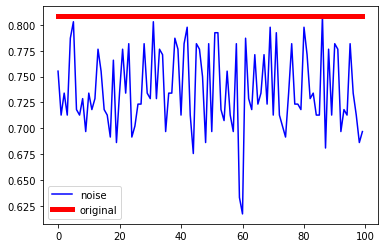

In [ ]:
Tree = DecisionTreeClassifier(min_samples_split=2,min_samples_leaf=9,random_state=0)
scoreTestnoise=np.zeros(100)
scoreTest=np.zeros(100)
mu = 0
sigma = 0.05 
Tree.fit(X_train,y_train)
scoreTest[:] = Tree.score(X_test,y_test)  

for k in range(100):    
    X_train_temp=np.copy(X_train)
    noise = np.abs (np.random.normal(mu,sigma))
    for i in range(X_train.shape[0]):
        X_train_temp[i] = X_train_temp[i] + noise
        
    Tree.fit(X_train_temp,y_train)
    scoreTestnoise[k] = Tree.score(X_test,y_test)
    
plt.plot(scoreTestnoise,'b',label='noise')
plt.plot(scoreTest,'r',linewidth=5.0,label='original')       
plt.legend();

**Answer:**
* After looking at the figure, we can clearly see that the results are not stable. In fact, after adding just a little noise to our data, the results scores changed a lot.
* This confirms that decision tree classifier has a high variance. 
* I think we could use random forest to avoid this problem.

To plot decision trees, we can also use the *graphviz* library. If you need to install it locally, you can do it using *conda install python-graphviz*. 
 

First plot the tree learnt on the original data, witout adding noise.

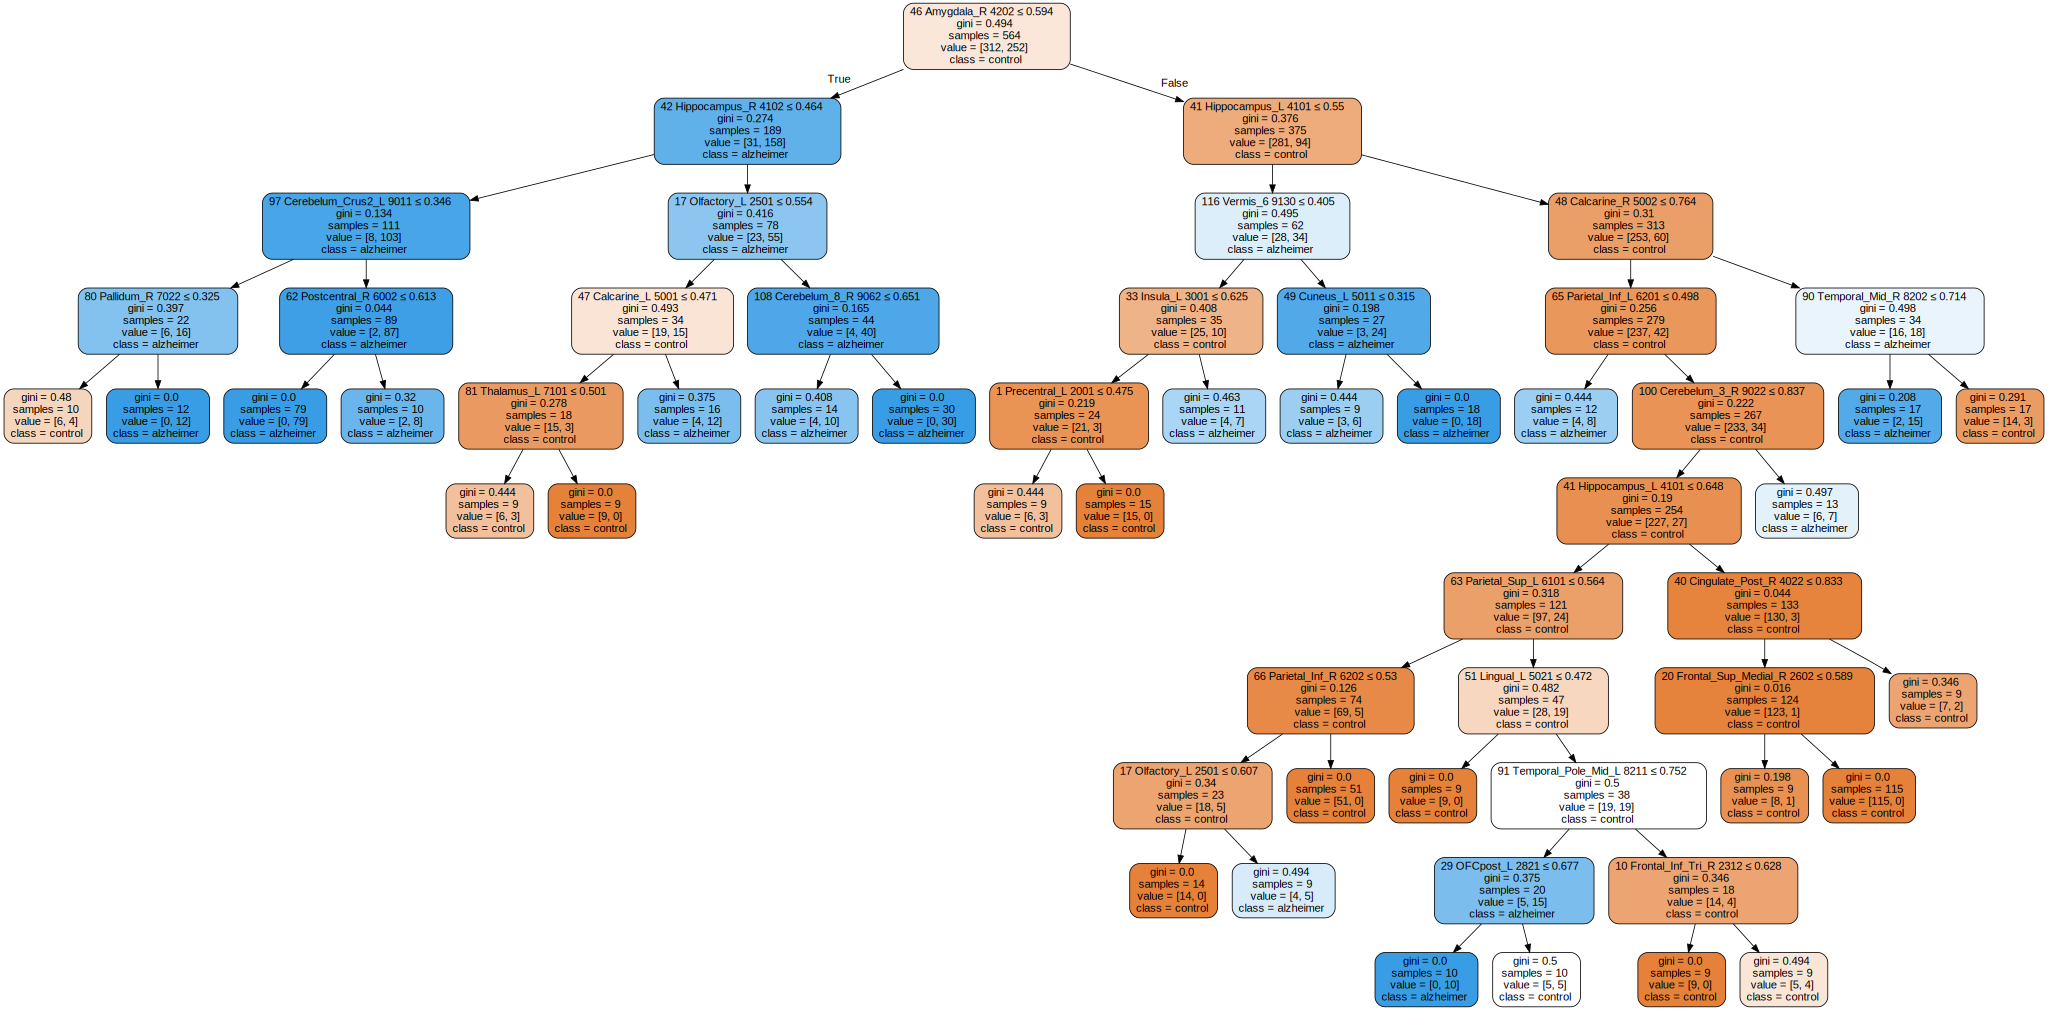

In [ ]:
import graphviz 

Tree.fit(X_train,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

Now, plot the tree learnt on noisy data.

**Question**: Is it the same ? You can try several times, for different levels of noise. Comment the results

* for $σ = 0.05$

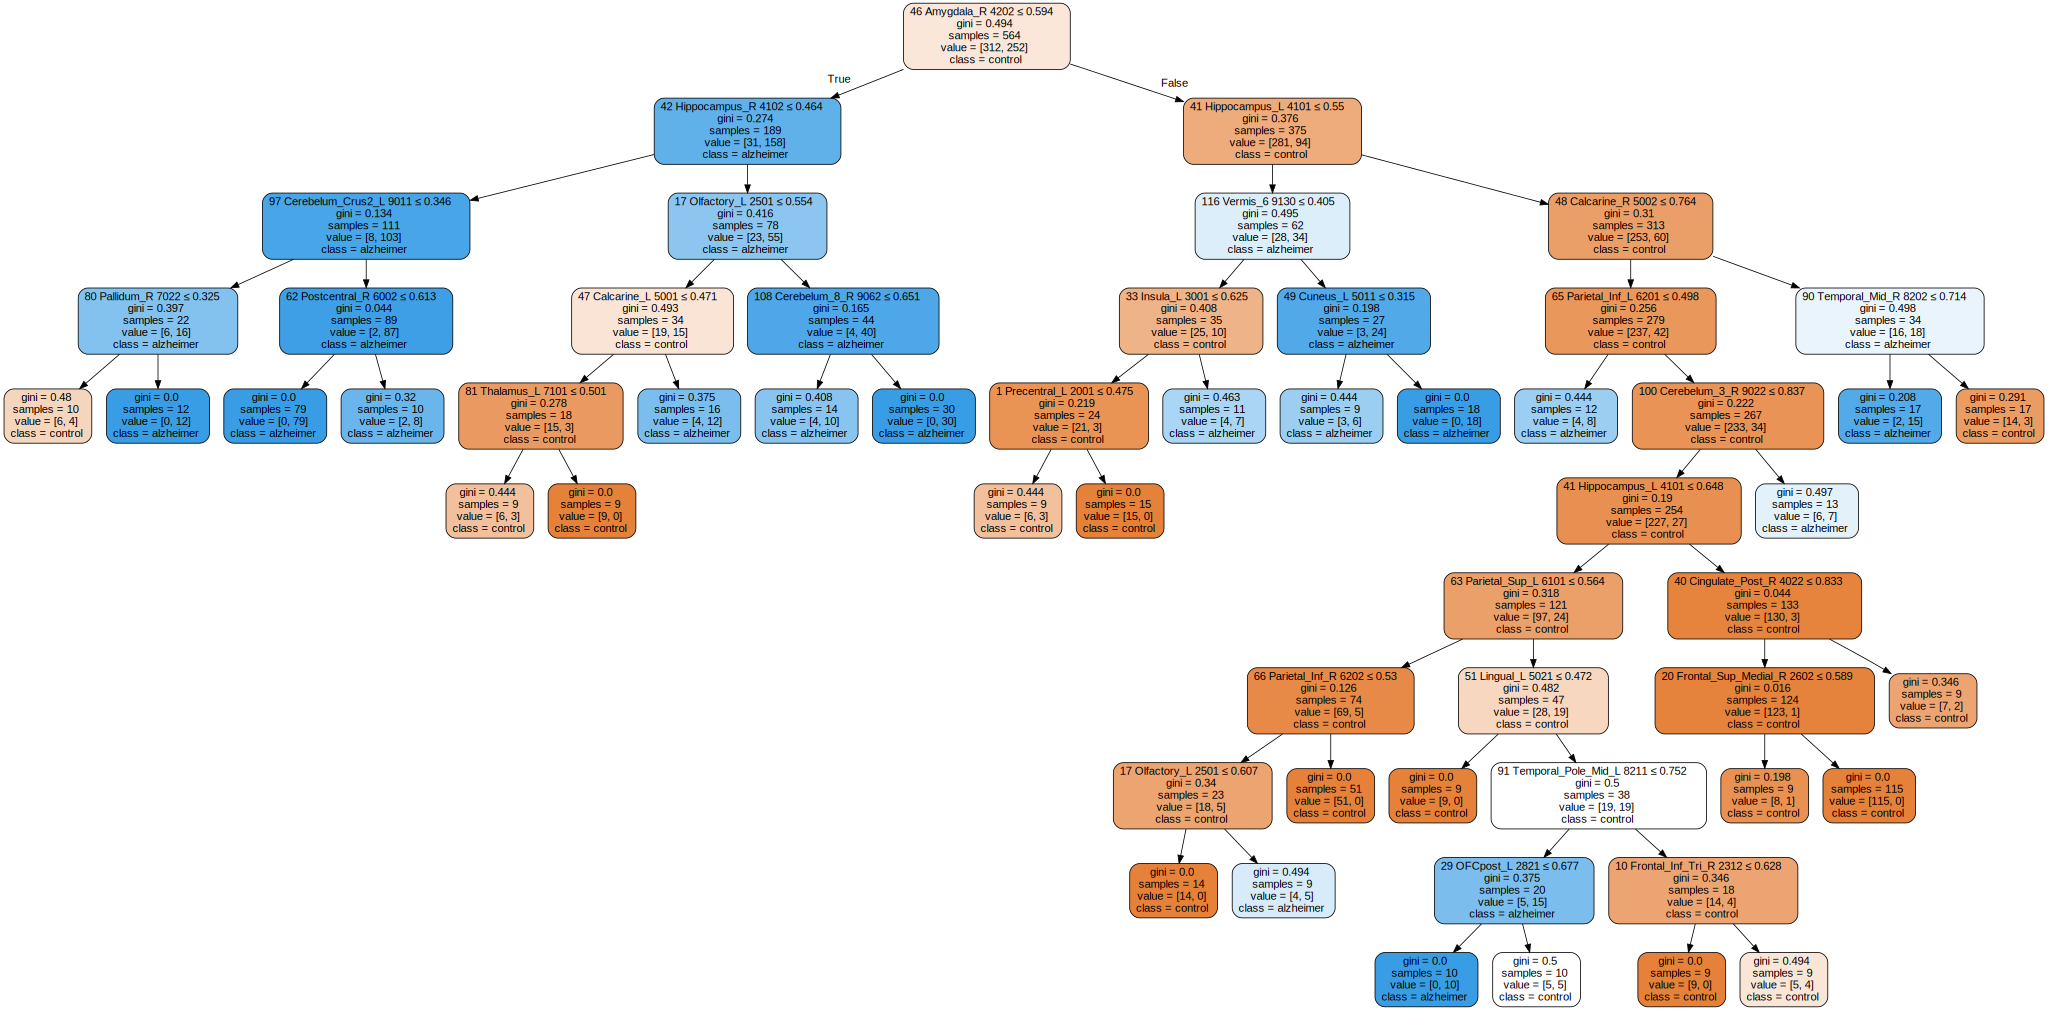

In [ ]:
mu =0 
sigma = 0.05
X_train_temp=np.copy(X_train)
noise  = np.abs(np.random.normal(mu, sigma)) 
for i in range(X_train.shape[0]):
    X_train_temp[i] = X_train_temp[i] + noise
Tree.fit(X_train,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

* for $σ = 0.5$

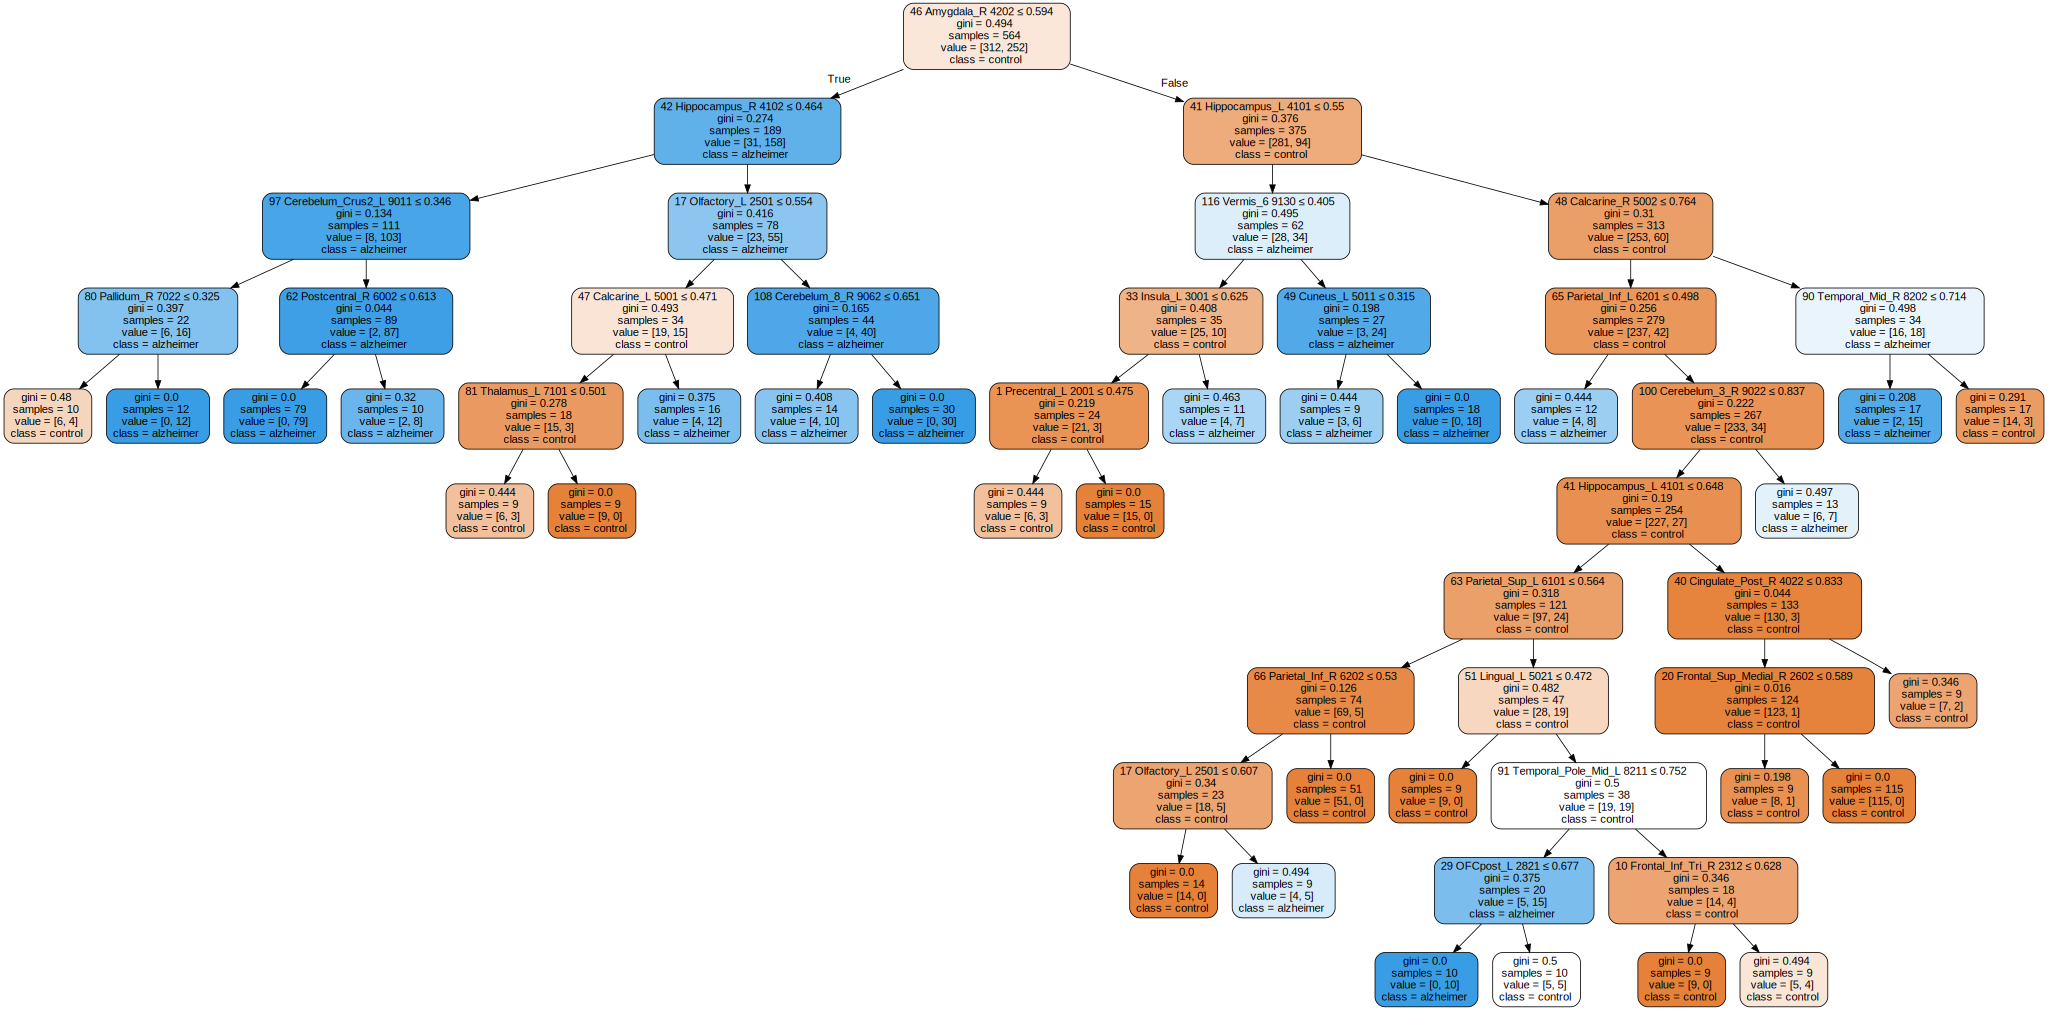

In [ ]:
mu =0 
sigma = 0.5
X_train_temp=np.copy(X_train)
noise  = np.abs(np.random.normal(mu, sigma)) 
for i in range(X_train.shape[0]):
    X_train_temp[i] = X_train_temp[i] + noise
Tree.fit(X_train,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

* for $σ = 1$

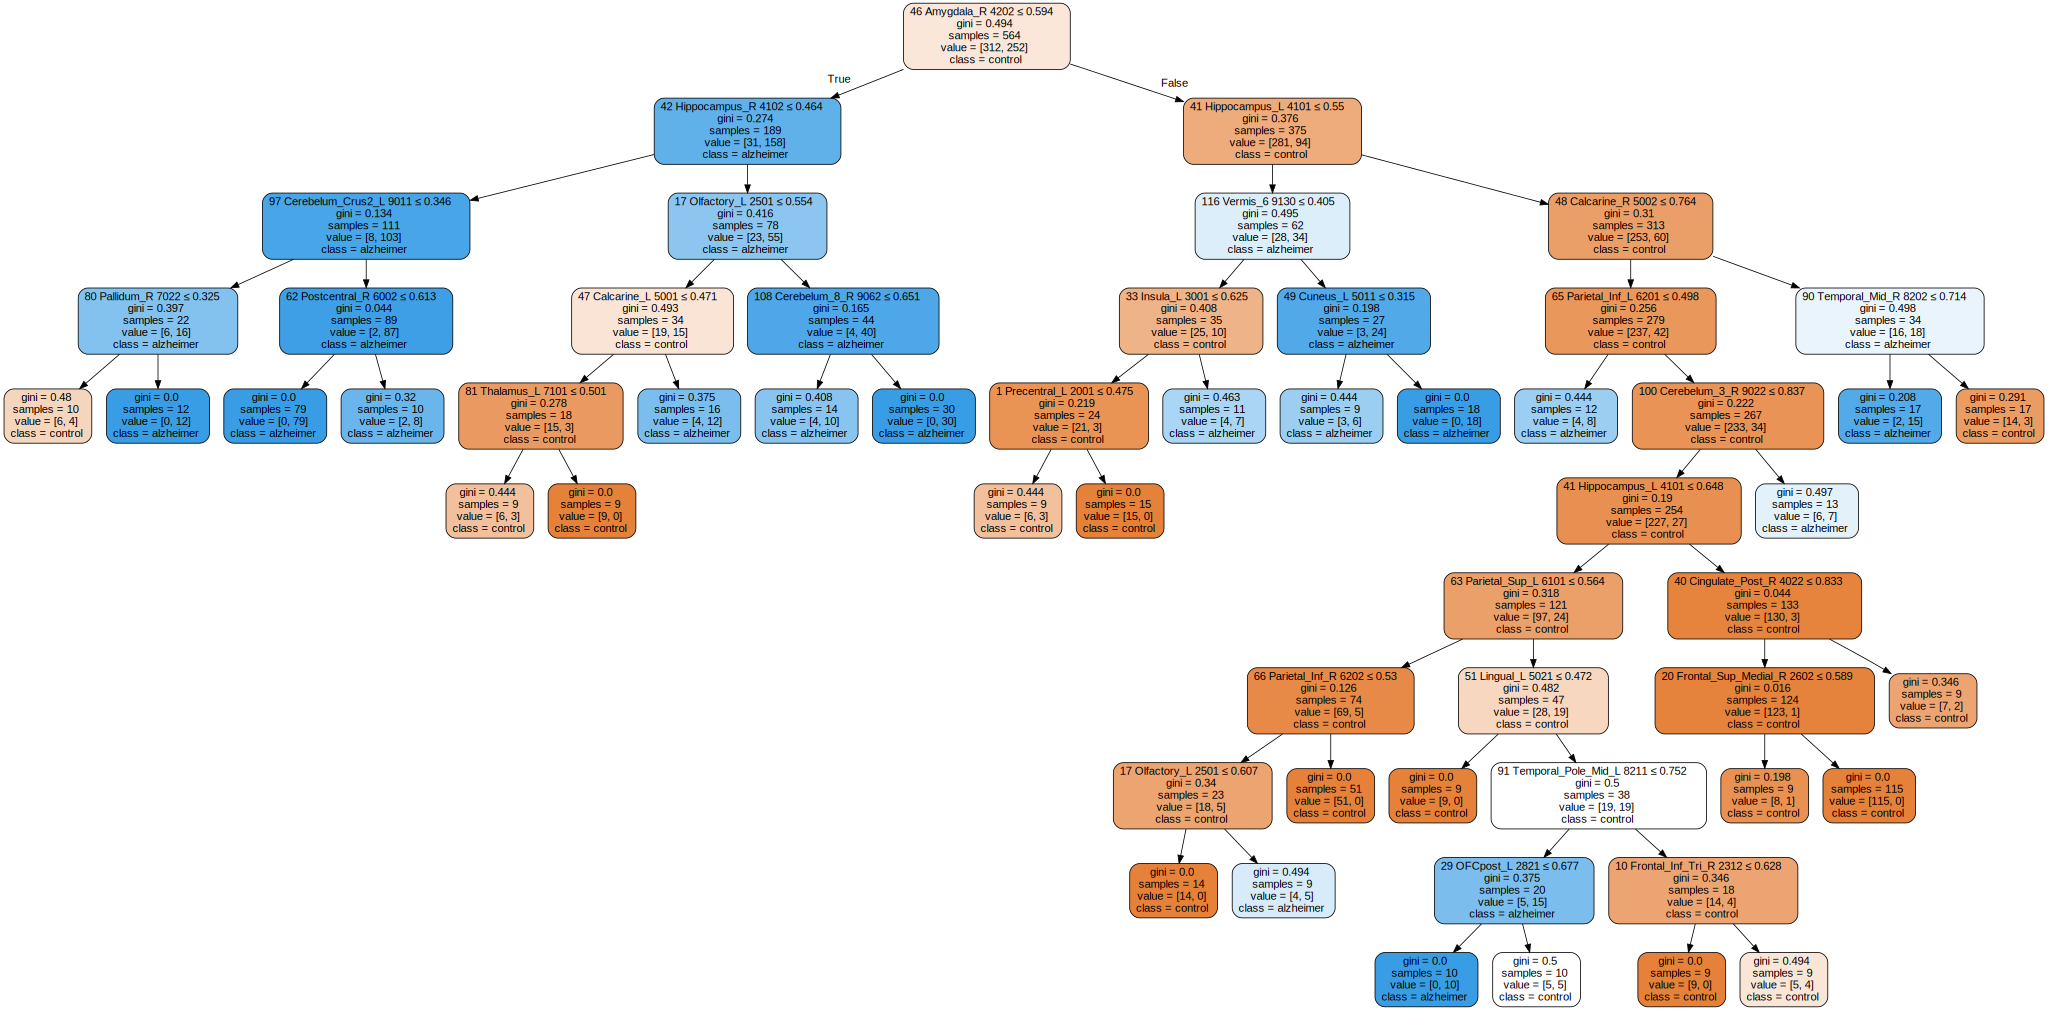

In [ ]:
mu =0 
sigma = 1
X_train_temp=np.copy(X_train)
noise  = np.abs(np.random.normal(mu, sigma)) 
for i in range(X_train.shape[0]):
    X_train_temp[i] = X_train_temp[i] + noise
Tree.fit(X_train,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

* for $σ = 5$

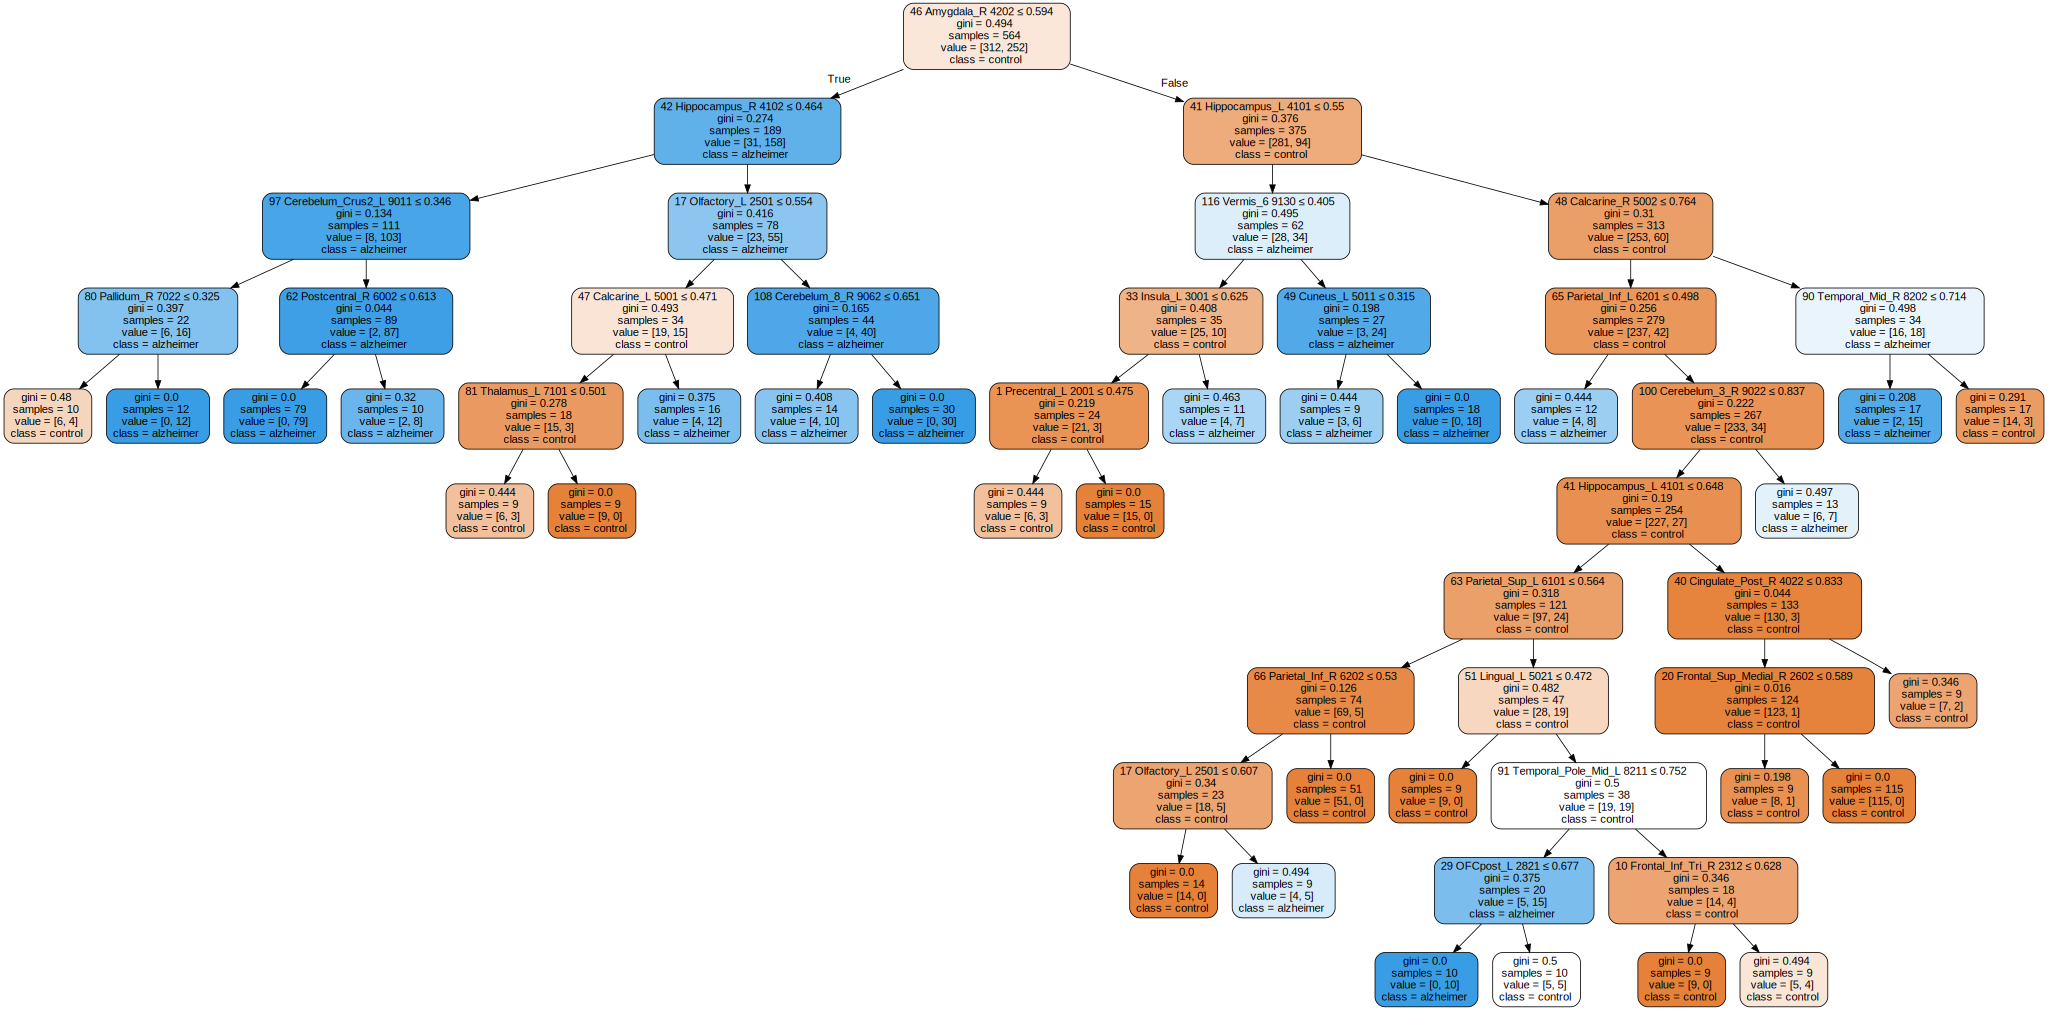

In [ ]:
mu =0 
sigma = 5
X_train_temp=np.copy(X_train)
noise  = np.abs(np.random.normal(mu, sigma)) 
for i in range(X_train.shape[0]):
    X_train_temp[i] = X_train_temp[i] + noise
Tree.fit(X_train,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

* for $σ = 10$

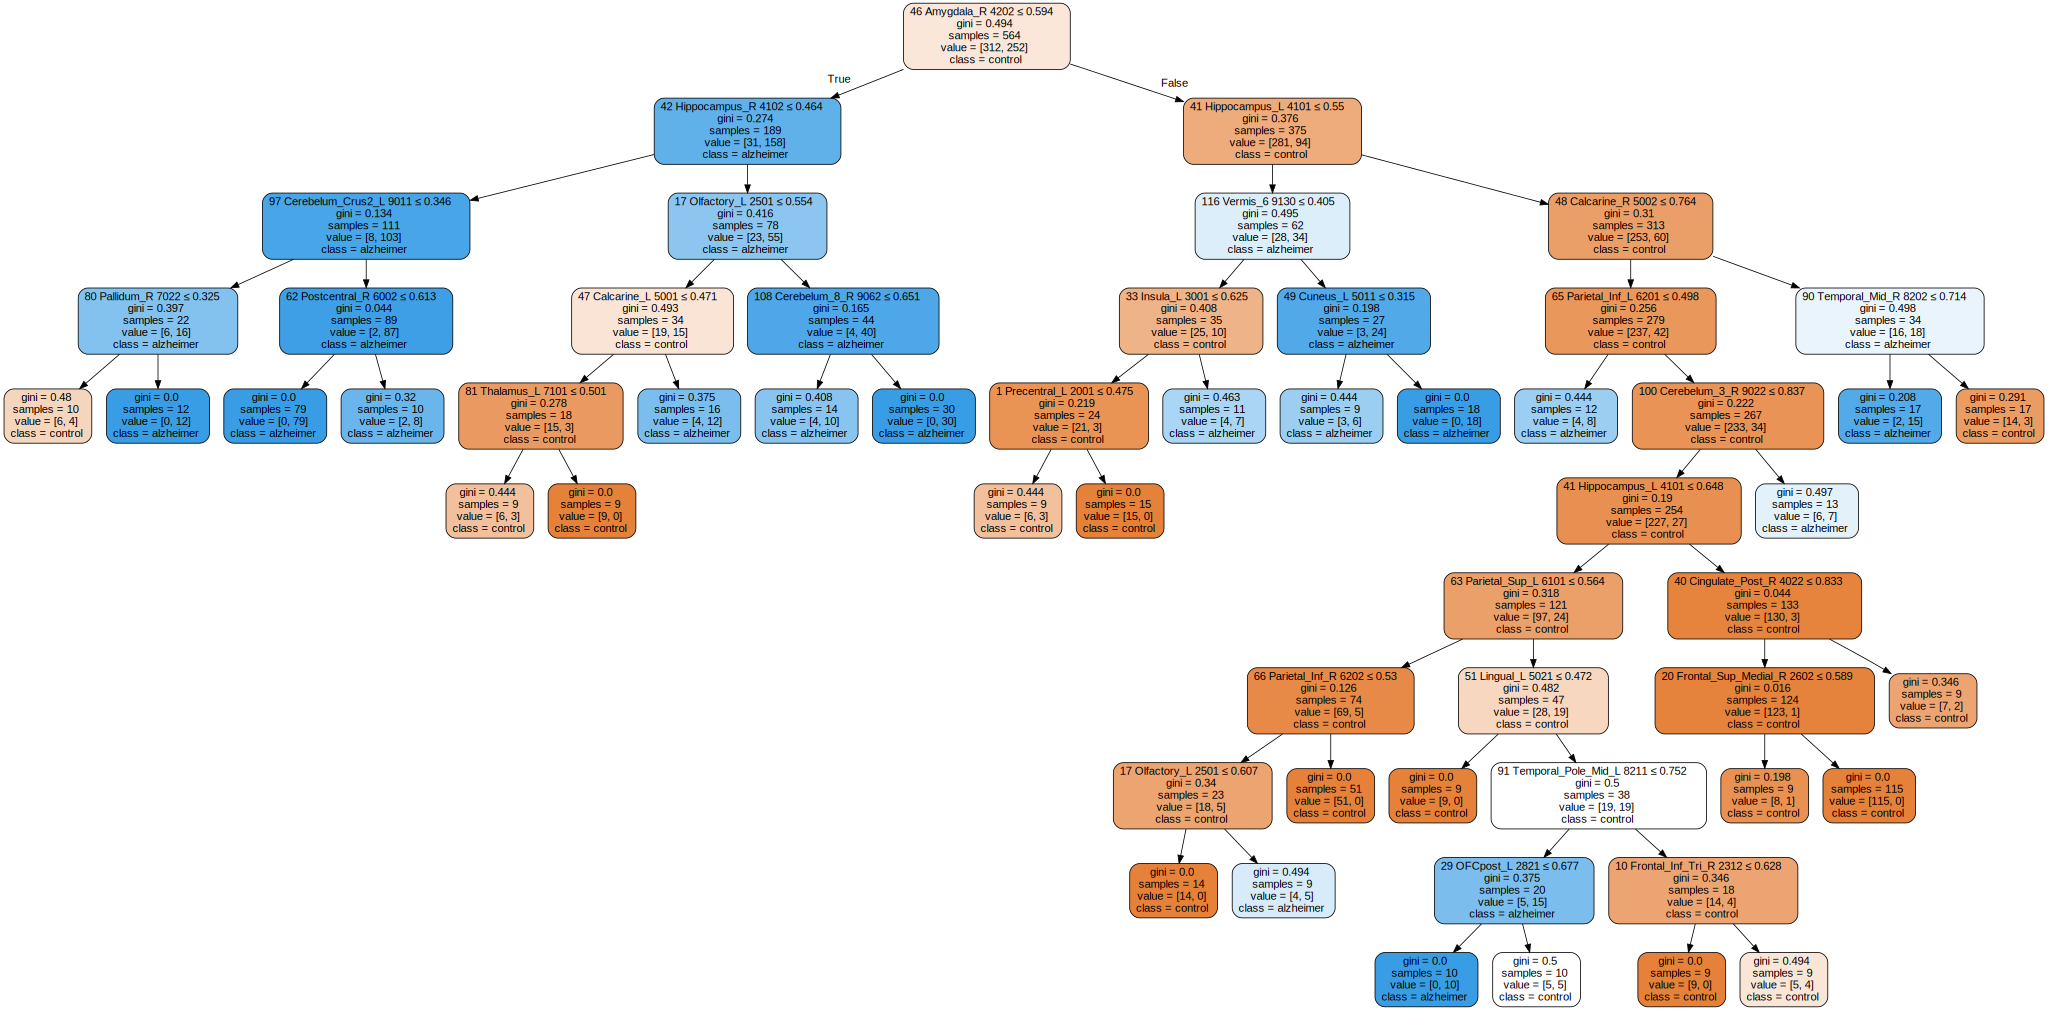

In [ ]:
mu =0 
sigma = 10
X_train_temp=np.copy(X_train)
noise  = np.abs(np.random.normal(mu, sigma)) 
for i in range(X_train.shape[0]):
    X_train_temp[i] = X_train_temp[i] + noise
Tree.fit(X_train,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

**Answer:**
* In the previous section, i tried to vary as much as possible the level of noise.
* I noticed that at the top of the tree, we always split on the same features(eventhough we do that with different threshold). We can see the differences only at the bottom of the tree.


Instead than using a single split of the data, we could also use Cross Validation to compute the best hyperparameter values for both 'min_samples_split' and 'min_samples_leaf' at the same time and in an automatic way. 

**Question:** Do you find the same optimal hyperparameters as before ? Hint: use GridSearchCV



In [ ]:
Tree = DecisionTreeClassifier()
p_grid_tree = {'min_samples_split':list(range(2,20)),'min_samples_leaf':list(range(2,20))} 
grid_tree = GridSearchCV(Tree,p_grid_tree)
grid_tree.fit(X_train,y_train)
print("Best Validation Score: {}".format(grid_tree.best_score_))
print("Best params: {}".format(grid_tree.best_params_))
print("Tree test score :",grid_tree.score(X_test,y_test))

Best Validation Score: 0.7642225031605563
Best params: {'min_samples_leaf': 7, 'min_samples_split': 5}
Tree test score : 0.7606382978723404


**Answer:**
* No, i didn't find the same optimal hyperparameters as before.
* It is logical since we are using the function GridSearchCV which will make an exhaustive search over the different combinations of 'min_samples_split" and "min_samples_leaf".
* This is different from what we did before when we searched on the best value of each hyperparameter independently.As a result, obtaining different values is reasonable.

**Question**: So far, we have used the standard score (ie accuracy). Would you use a different one ? If yes, which one and why ?

**Answer:**
* While considering data related to medical problems, we always try to minimize as much as possible the False Negatives and the False Positives.
* Using the standard score (accuracy), we don't get reliable results as we have seen in the previous TP. To do so, we can consider using the f1_score.

Using the estimated optimal hyperparameers, plot the new decision tree using the *graphviz* library. 

**Question**: Is it the same as before? Do you see ROIs that are always close to the root of the tree among the different experiments ? If yes, what does it mean in your opinion ? Comment the results.

**Answer:**
* We can see that the global structure of the decision tree is the same as before, but we have different threshholds since we are udsing different hyperparameters.
* While checking the different trees we obtained from the begining of the TP, we can see that some features are always close to the root. for example the features **46 Amygdala_R 4202** ,**42 Hippocampus_R 4102** and **41 Hippocampus_L 4101** are always on the top.
* Those features have the minimal gini indexes in comparison with all different features.This means that they are the most important ones in determining whether a person has alzheimer or not.

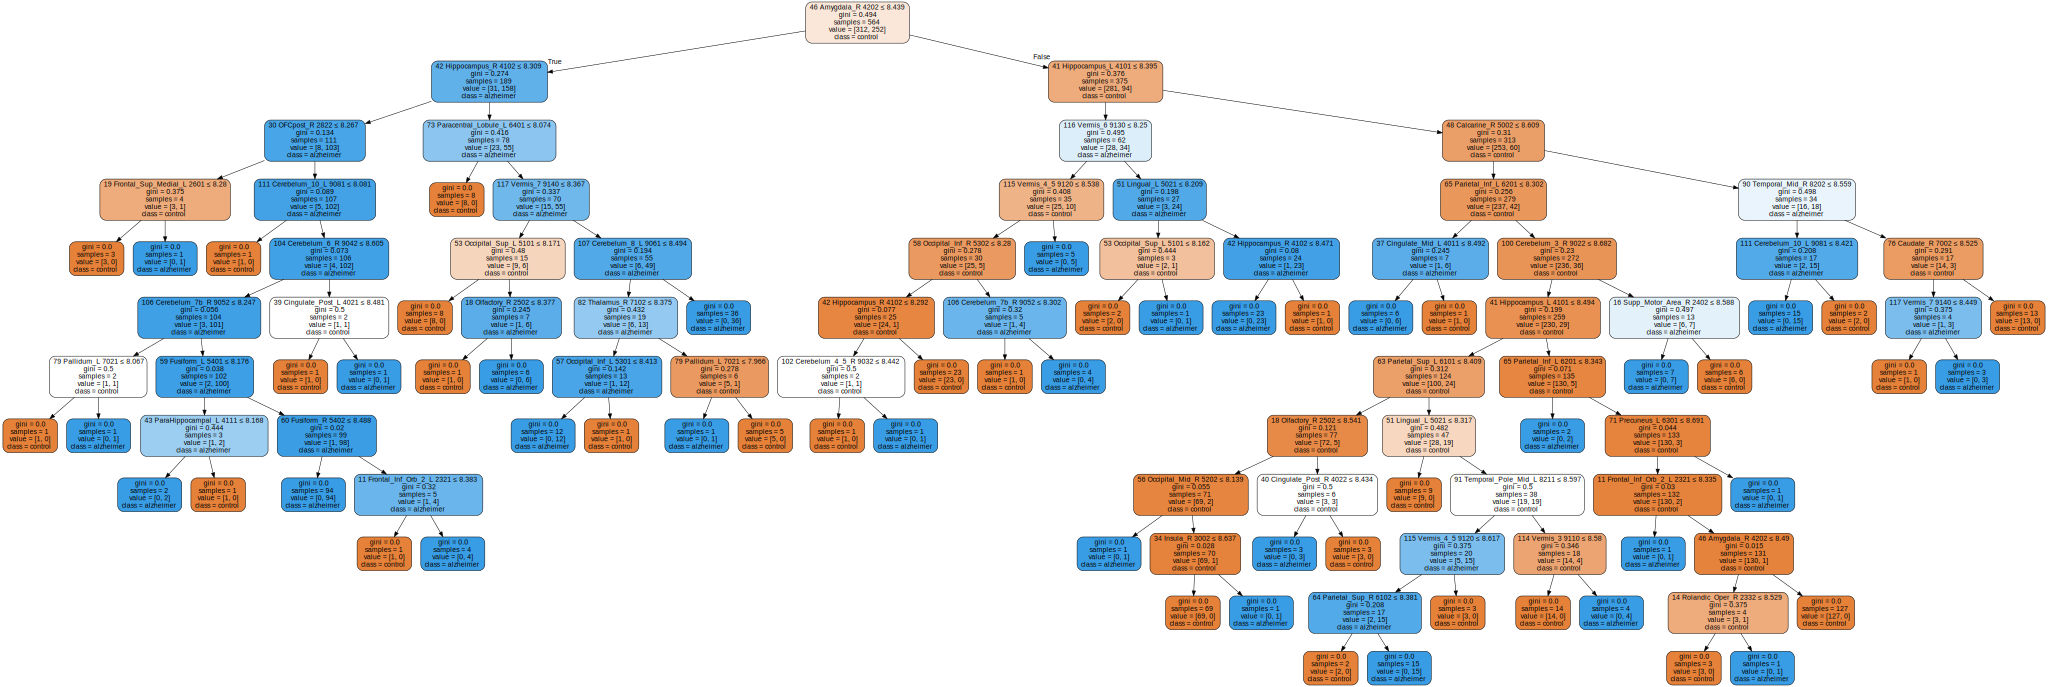

In [ ]:
Tree.fit(X_train_temp,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

Try to use now Bagging. You can use the following code where we use the previously computed best parameters 'min_samples_leaf' and 'min_samples_split'. 

**Question**: What happens when you use the original data and the noisy version ? Do you notice any difference in the prediction scores with respect to the results using Decision Trees ? 

**Answer:**
* While comparing the obtained results with the results using basic Decision Trees, we can see that the score went from 0.75 to 0.83 with bagging on original data. So it is clear that using this method gives better results.
* While considering the noisy data, we can see that we had as score the value of 0.78. it is higher than the result with original data and basic decision trees.
*These results confirms that the bagging method reduces the high variance of a decision tree, which is one of the biggest problems of such a classifier

In [ ]:
Tree = DecisionTreeClassifier(min_samples_leaf= grid_tree.best_params_["min_samples_leaf"] ,min_samples_split=grid_tree.best_params_["min_samples_split"], random_state=0)
p_grid_bagging = {'n_estimators': [5,10,15,20]}      
bag=BaggingClassifier(base_estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(bag, p_grid_bagging)
grid_bagging.fit(X_train, y_train.ravel())
print("Best Validation Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging test score :",grid_bagging.score(X_test,y_test))

Best Validation Score: 0.8155973451327434
Best params: {'n_estimators': 10}
Bagging test score : 0.8297872340425532


In [ ]:
# Bagging on noisy data
mu =0 
sigma = 0.05
X_train_temp=np.copy(X_train)
noise  = np.abs(np.random.normal(mu, sigma)) 
for i in range(X_train.shape[0]):
    X_train_temp[i] = X_train_temp[i] + noise
Tree = DecisionTreeClassifier(min_samples_leaf= grid_tree.best_params_["min_samples_leaf"] ,min_samples_split=grid_tree.best_params_["min_samples_split"], random_state=0)
p_grid_bagging = {'n_estimators': [5,10,15,20]}      
bag=BaggingClassifier(base_estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(bag, p_grid_bagging)
grid_bagging.fit(X_train_temp, y_train.ravel())
print("Best Validation Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging test score :",grid_bagging.score(X_test,y_test))

Best Validation Score: 0.8155973451327434
Best params: {'n_estimators': 10}
Bagging test score : 0.7872340425531915


The last part of this TP is about Random Forests. We can estimate the three hyperparameters *'n_estimators'*, *'min_samples_leaf'* and *'max_features'*, the number of features to consider when looking for the best split, as before using Cross Validation

In [ ]:
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring='accuracy', cv=5)
grid_RF.fit(X_train, y_train.ravel())

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test,y_test))

Best Validation Score: 0.8156289506953224
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 30}
Random Forest test score : 0.8085106382978723


Using the estimated best hyperparameters, test the performance of Random Forest on the noisy data and compare the results with Decision Trees and Bagging. 

**Answer:**
* While using random forest on noisy data, we can see that we obtained a really better result than basic decision tree with best hyperparameters. It is also better than the result obtained with bagging and noisy data.

In [ ]:
# Random Forest on noisy data
mu =0 
sigma = 0.05
X_train_temp=np.copy(X_train)
noise  = np.abs(np.random.normal(mu, sigma)) 
for i in range(X_train.shape[0]):
    X_train_temp[i] = X_train_temp[i] + noise
grid_RF.fit(X_train_temp, y_train.ravel())
print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test,y_test))

Best Validation Score: 0.8156289506953224
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 30}
Random Forest test score : 0.8031914893617021


We can also use Random Forests to check the importance of the features

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Feature ranking:
1. feature 45 representing 46 Amygdala_R 4202
 (0.093414)
2. feature 44 representing 45 Amygdala_L 4201
 (0.074155)
3. feature 41 representing 42 Hippocampus_R 4102
 (0.064192)
4. feature 43 representing 44 ParaHippocampal_R 4112
 (0.042967)
5. feature 92 representing 93 Temporal_Inf_L 8301
 (0.040970)
6. feature 40 representing 41 Hippocampus_L 4101
 (0.038121)
7. feature 93 representing 94 Temporal_Inf_R 8302
 (0.031619)
8. feature 59 representing 60 Fusiform_R 5402
 (0.023090)
9. feature 42 representing 43 ParaHippocampal_L 4111
 (0.020165)
10. feature 69 representing 70 Angular_R 6222
 (0.016015)


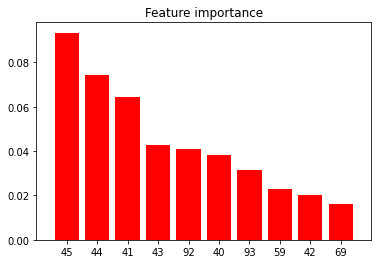

In [ ]:
best_params=grid_RF.best_params_
RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

**Question**: Which are the most important features (i.e. ROIs) ?  Based on the two given research papers, you can verify if your results make sense. 

**Answer:**
* According to the graph, the most important features to detect alzheimer are:
   * 46 Amygdala_R 4202 - 45 Amygdala_L 4201
   * 42 Hippocampus_R 4102 - 41 Hippocampus_L 4101
   * 44 ParaHippocampal_R 4112 - 43 ParaHippocampal_L 4111
   * 93 Temporal_Inf_L 8301 - 94 Temporal_Inf_R 8302
* While computing the different trees from the beginning of the TP, we can see that some of these features were the closest to root(more important than the others).
* In both papers, the importance of the amygdala and the hippocampus and the temporal lobes is noted. This can confirm that our results make sense


We can also inspect the data using only pairs of the most important features

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
/usr/loc

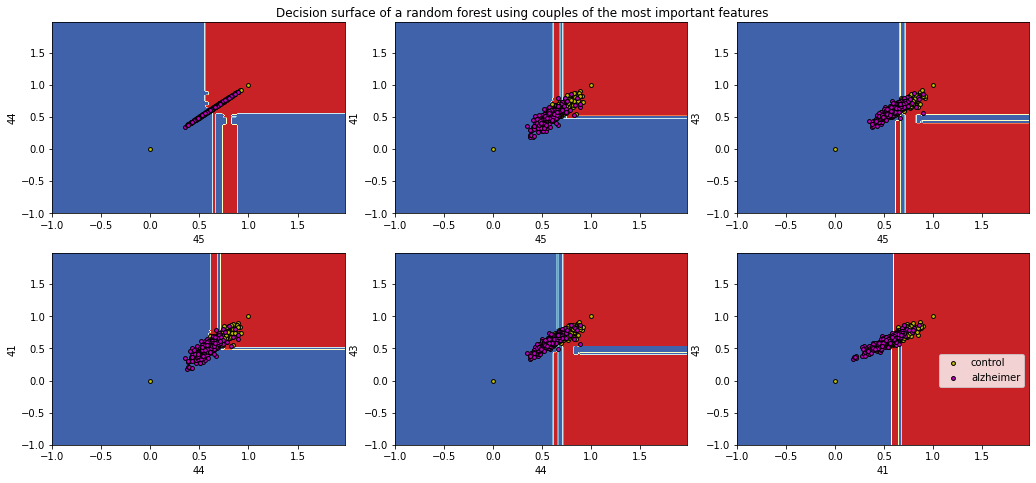

In [ ]:
plt.figure(figsize=(15,7))
for pairidx, pair in enumerate([ [indices[0],indices[1]], [indices[0],indices[2]], [indices[0],indices[3]],
                                [indices[1],indices[2]], [indices[1],indices[3]], [indices[2],indices[3]] ]):
    # We only take the two corresponding features
    Xpair = X_train[:, pair]
    ypair = y_train

    # Train
    clf = RF.fit(Xpair, ypair)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = Xpair[:, 0].min() - 1, Xpair[:, 0].max() + 1
    y_min, y_max = Xpair[:, 1].min() - 1, Xpair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(pair[0])
    plt.ylabel(pair[1])

    # Plot the training points
    for i, color in zip(range(2), "ym"):
        idx = np.where(ypair == i)
        plt.scatter(Xpair[idx, 0], Xpair[idx, 1], c=color, label=class_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a random forest using couples of the most important features")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.axis("tight")
plt.show()

**Question**: Which is the best couple of features ?

**Answer:**
* The best couple of features that seperate with less error is (45,41)or(44,41).
* I took this decision since the number of alzheimer subjects that exists in the wrong side is the smallest. It is the same for the control subjects.

**Different Atlas**

Previously, we have used the AAL2 which defines a precise split of the brain into ROIs. What happens if you change Atlas ? Do you obtain the same results ? Can you find a subset of ROIs that you could define 'biomarkers' of the Alzheimer's disease ? Justify your answer and check whether it makes sense by using the two given research papers.

You can use the AICHA (http://www.gin.cnrs.fr/fr/outils/aicha/) and HAMMERS (https://brain-development.org/brain-atlases/adult-brain-atlases/) atlas.

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 192
Best Validation Score: 0.7695796460176991
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 20}
Random Forest test score : 0.7712765957446809
Feature ranking:
1. feature 144 representing 145	S_Parietooccipital-4	146
 (0.056709)
2. feature 170 representing 171	G_Fusiform-6	172
 (0.030861)
3. feature 187 representing 188	N_Thalamus-5	189
 (0.027598)
4. feature 172 representing 173	N_Amygdala-1	174
 (0.023685)
5. feature 173 representing 174	N_Caudate-1	175
 (0.018978)
6. feature 171 representing 172	G_Fusiform-7	173
 (0.018051)
7. feature 145 representing 146	S_Parietooccipital-5	147
 (0.017681)
8. feature 111 representing 112	G_Supp_Motor_Area-2	113
 (0.017117)
9. feature 181 representing 182	N_Putamen-2	183
 (0.016915)
10. feature 185 representing 186	N_Thalamus-3	187
 (0.013832)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


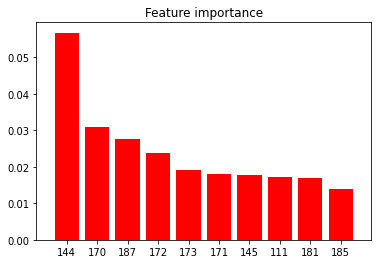

In [ ]:
# Choose Atlas (here AICHA)
X=T1AICHA # T1AAL2, T1AICHA, T1HAMMERS
labels=ROIlabelsAICHA # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas='./AtlasAICHA.nii' #AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify=y)
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring='accuracy', cv=5) # I used the accuracy as a metric in order to keep the comparision between the classifiers ( normaly it's better to use f1-score)
grid_RF.fit(X_train, y_train.ravel())

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test,y_test))
best_params=grid_RF.best_params_
RF = RandomForestClassifier(min_samples_leaf=grid_RF.best_params_["min_samples_leaf"],max_features=grid_RF.best_params_["max_features"],n_estimators=grid_RF.best_params_["n_estimators"], random_state=0)
RF.fit(X_train,y_train)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

**Answer:**
* The ROIs given by T1AICHA are different from the other ones generated with T1HAMMERS & T1AAL2.
* We still can see the presence of some features among the important ones like Amygdala.
* We can see that the most important features for this case are S_Parietooccipital-4,G_Fusiform-6,and 188	N_Thalamus-5 ..

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 68
Best Validation Score: 0.8156447534766119
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 30}
Random Forest test score : 0.8457446808510638
Feature ranking:
1. feature 3 representing Right Amygdala                         (0.118962)
2. feature 0 representing Left Hippocampus                       (0.068654)
3. feature 1 representing Right Hippocampus                      (0.047669)
4. feature 2 representing Left Amygdala                          (0.041185)
5. feature 5 representing Right Anterior Medial Temporal Lobe    (0.035308)
6. feature 46 representing Left Lateral Temporal Ventricle        (0.033467)
7. feature 12 representing Left Inferior Middle Temporal Gyri     (0.029626)
8. feature 8 representing Left Ambient and Parahippocampus Gyri  (0.024044)
9. feature 4 representing Left Anterior Medial Temporal Lobe     (0.024029)
10. feature 47 repres

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


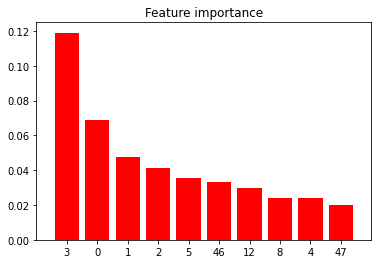

In [ ]:
# Choose Atlas (here T1HAMMERS)
X=T1HAMMERS # T1AAL2, T1AICHA, T1HAMMERS
labels=ROIlabelsHAMMERS # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas='./AtlasHAMMERS.nii' #AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify=y)
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring='accuracy', cv=5) # I used the accuracy as a metric in order to keep the comparision between the classifiers ( normaly it's better to use f1-score)
grid_RF.fit(X_train, y_train.ravel())

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test,y_test))
best_params=grid_RF.best_params_
RF = RandomForestClassifier(min_samples_leaf=grid_RF.best_params_["min_samples_leaf"],max_features=grid_RF.best_params_["max_features"],n_estimators=grid_RF.best_params_["n_estimators"], random_state=0)
RF.fit(X_train,y_train)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

**Answer:**
* While using the T1HAMMERS to present the data, we can clearly see that we obtained the Right & Left Amygdala , Right & Left Hippocamus and Parahippocampus as the most important features. 
* Those features also appeared with the ALL2 atlas so this makes us more sure that our results make sense

**Conclusion**:
* So, after using the T1AAL2 atlas,the T1AICHA atlas and T1HAMMERS atlas, we can clearly see that one of the most important features is Amygdala.
* Moreover, we can see that Hippocamus and ParaHippocampal are also important to detect whether a subject has alzheimer or not.